In [ ]:
import os
import subprocess
import pandas as pd
import re

def extract_video_duration(video_path):
    
    
    ffmpeg_path = "/opt/homebrew/bin/ffmpeg"  # Path to FFmpeg executable
    cmd = [ffmpeg_path, "-i", video_path]
    result = subprocess.run(cmd, stderr=subprocess.PIPE, stdout=subprocess.PIPE, text=True)
    
    duration_match = re.search(r"Duration: (\d+):(\d+):(\d+\.\d+)", result.stderr)
    if duration_match:
        hours, minutes, seconds = map(float, duration_match.groups())
        return hours * 3600 + minutes * 60 + seconds  # Convert to total seconds
    else:
        return None  # Return None if duration not found

def process_video_folder(root_folder, output_csv):
    """Processes all videos in nested subfolders (genres and segmented scenes) and extracts their duration, saving to CSV."""
    data = []
    
    if not os.path.exists(root_folder):
        print(f"❌ Error: Folder '{root_folder}' does not exist.")
        return
    
    print(f" Searching in root folder: {root_folder}")
    
    for genre in sorted(os.listdir(root_folder)):
        genre_path = os.path.join(root_folder, genre.strip())
        
        if os.path.isdir(genre_path):  # Ensure it's a directory
            print(f"Checking genre folder: {genre_path}")
            
            for subfolder in sorted(os.listdir(genre_path)):
                subfolder_path = os.path.join(genre_path, subfolder.strip())
                
                if os.path.isdir(subfolder_path):  # Ensure it's a scene segment folder
                    print(f"📁 Checking scene subfolder: {subfolder_path}")
                    
                    try:
                        video_files = [f.strip() for f in os.listdir(subfolder_path) if f.lower().endswith(('.mp4', '.avi', '.mov'))]
                    except Exception as e:
                        print(f"⚠️ Error reading files in '{subfolder_path}': {e}")
                        continue
                    
                    print(f" Found files in {subfolder}: {video_files}")  # Debugging Output
                    
                    if not video_files:
                        print(f"⚠️ Warning: No video files found in '{subfolder_path}'.")
                        continue
                    
                    for video in video_files:
                        video_path = os.path.join(subfolder_path, video)
                        
                        if not os.path.exists(video_path):
                            print(f"⚠️ Warning: File '{video_path}' not found or inaccessible.")
                            continue
                        
                        print(f" Processing: {video_path}")
                        duration = extract_video_duration(video_path)
                        
                        if duration is not None:
                            match = re.match(r".*scene_(\d+)\.mp4", video)
                            scene_number = int(match.group(1)) if match else None
                            data.append([video, genre, subfolder, scene_number, duration])
    
    if not data:
        print("❌ Error: No valid scene durations found.")
        return
    
    # Save to DataFrame
    df = pd.DataFrame(data, columns=["filename", "genre", "film", "scene_number", "duration_seconds"])
    df.to_csv(output_csv, index=False)
    print(f"✅ Scene durations saved to: {output_csv}")

# Example Usage
video_folder = "/Users/alicja/Desktop/VideoAnalyse/Corpus/VideoSegmentation"  
output_csv = "scene_durations.csv"
process_video_folder(video_folder, output_csv)



📂 Searching in root folder: /Users/alicja/Desktop/VideoAnalyse/Corpus/VideoSegmentation
🔍 Checking genre folder: /Users/alicja/Desktop/VideoAnalyse/Corpus/VideoSegmentation/ActionSegments
📁 Checking scene subfolder: /Users/alicja/Desktop/VideoAnalyse/Corpus/VideoSegmentation/ActionSegments/Action_01_RETRIBUTION｜  Action Short film
📄 Found files in Action_01_RETRIBUTION｜  Action Short film: ['Action_01_RETRIBUTION｜  Action Short film_scene_133.mp4', 'Action_01_RETRIBUTION｜  Action Short film_scene_127.mp4', 'Action_01_RETRIBUTION｜  Action Short film_scene_20.mp4', 'Action_01_RETRIBUTION｜  Action Short film_scene_34.mp4', 'Action_01_RETRIBUTION｜  Action Short film_scene_2.mp4', 'Action_01_RETRIBUTION｜  Action Short film_scene_245.mp4', 'Action_01_RETRIBUTION｜  Action Short film_scene_251.mp4', 'Action_01_RETRIBUTION｜  Action Short film_scene_250.mp4', 'Action_01_RETRIBUTION｜  Action Short film_scene_244.mp4', 'Action_01_RETRIBUTION｜  Action Short film_scene_3.mp4', 'Action_01_RETRIBUTION

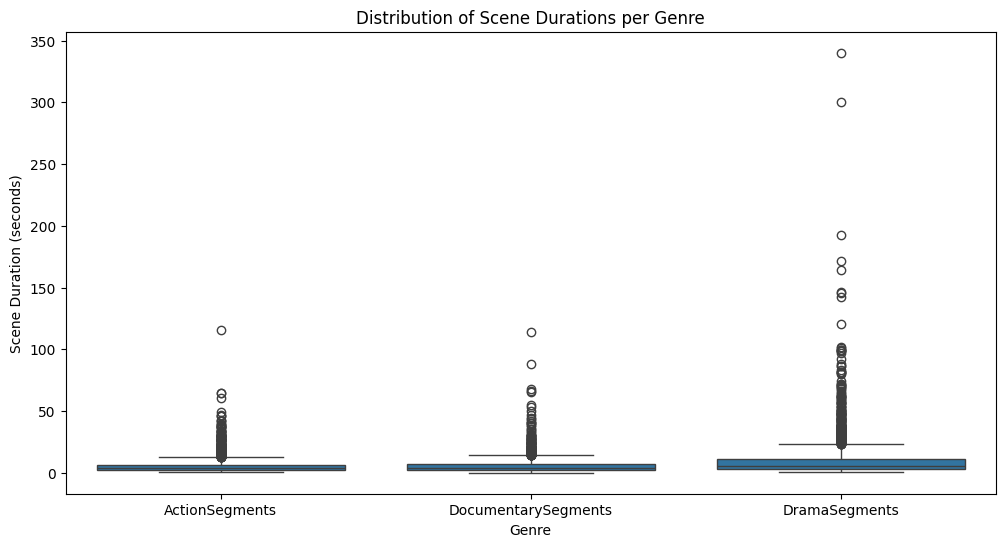

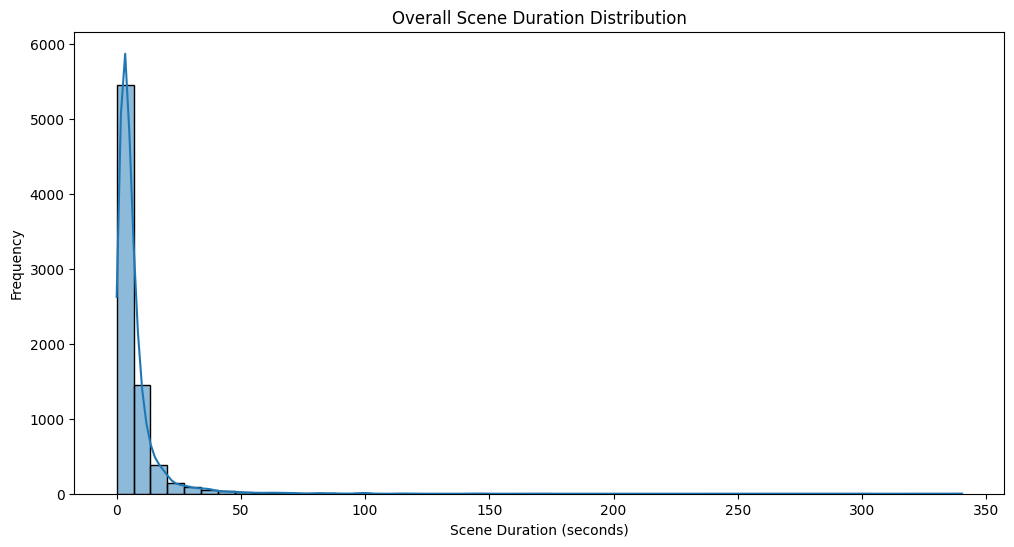

(                                                 film  avg_scene_duration
 0           Action_01_RETRIBUTION｜  Action Short film            3.113043
 1   Action_02_Apache ｜ Jason Statham ｜ New Action ...            5.816747
 2   Action_03_BUTCHER ：  New Action Movie 2025 ｜ J...            5.928415
 3   Action_04_Heist Gone Awry ｜ Wrong Place, Wrong...            5.360494
 4     Action_05_The Gunfighter (Best Short Film Ever)            2.865430
 5   Documentary_01_Kinabuhi - Award Winning Docume...            7.194417
 6   Documentary_02_Life at 122 °F： Surviving in th...            6.328577
 7    Documentary_03_The Phenomenon ｜ Full Documentary            6.481826
 8   Documentary_04_THE RAISIN (award-winning short...           13.921250
 9   Documentary_05_World's Most Feared Cartel ｜ Me...            4.630873
 10                   Drama_01_Nabokov on Kafka (1989)           36.279787
 11  Drama_02_PRADA presents ＂CASTELLO CAVALCANTI＂ ...           23.264000
 12    Drama_03_Shadowlan

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_scene_durations(csv_file):
    """Analyzes the scene duration dataset and generates visualizations."""
    scene_df = pd.read_csv(csv_file)
    scene_df["duration_seconds"] = pd.to_numeric(scene_df["duration_seconds"], errors="coerce")
    
    # Compute average scene duration per movie
    avg_scene_per_movie = scene_df.groupby("film")["duration_seconds"].mean().reset_index()
    avg_scene_per_movie.rename(columns={"duration_seconds": "avg_scene_duration"}, inplace=True)
    
    # Compute average scene duration per genre
    avg_scene_per_genre = scene_df.groupby("genre")["duration_seconds"].mean().reset_index()
    avg_scene_per_genre.rename(columns={"duration_seconds": "avg_scene_duration"}, inplace=True)
    
    # Compute standard deviation per genre
    std_scene_per_genre = scene_df.groupby("genre")["duration_seconds"].std().reset_index()
    std_scene_per_genre.rename(columns={"duration_seconds": "scene_duration_std"}, inplace=True)
    
    # Merge statistics per genre
    genre_stats = avg_scene_per_genre.merge(std_scene_per_genre, on="genre")
    
    # Visualization: Boxplot per genre
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="genre", y="duration_seconds", data=scene_df)
    plt.xlabel("Genre")
    plt.ylabel("Scene Duration (seconds)")
    plt.title("Distribution of Scene Durations per Genre")
    plt.show()
    
    # Visualization: Histogram of scene durations
    plt.figure(figsize=(12, 6))
    sns.histplot(scene_df["duration_seconds"], bins=50, kde=True)
    plt.xlabel("Scene Duration (seconds)")
    plt.ylabel("Frequency")
    plt.title("Overall Scene Duration Distribution")
    plt.show()
    
    return avg_scene_per_movie, genre_stats

csv_file = "scene_durations.csv"  
analyze_scene_durations(csv_file)